In [4]:
# Import Dependencies
import pandas as pd
import numpy as np
from scipy import optimize

# Plots as needed
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR

# DB interface
from sqlalchemy import create_engine
from config import db_password

## Interface with Database and create DataFrames

In [5]:
# Construct db string
user = 'postgres'
host = 'housing-prices.ch2ctomvepex.us-east-1.rds.amazonaws.com'
name = 'housing-prices'

db_string = f'postgresql://{user}:{db_password}@{host}/{name}'

In [6]:
# Create Connection Engine

engine = create_engine(db_string)

In [7]:
# Example - load data from RDS into pandas DataFrame

sf_db = pd.read_sql_table('sanfran', engine)
sf_db.head()

,price,bedroom,sqft,neighborhood,bathroom,amenity_count,cityid
0,3985,2,920.0,cole valley / ashbury hts,1.0,5,2
1,3961,1,745.0,SOMA / south beach,1.0,9,2
2,7435,3,1146.0,SOMA / south beach,2.0,9,2
3,2785,2,1000.0,alamo square / nopa,1.5,7,2
4,7250,3,1146.0,SOMA / south beach,2.0,9,2


In [17]:
# Example Data from CSV used here

# Import Data
sf_df = pd.read_csv("../../First Segment Rubric - Sample Data/sf_clean.csv")
sf_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


## Examine data

In [18]:
# Hood District previously deemed unimportant

sf_df = sf_df.drop(columns='hood_district', axis=1)

In [19]:
# List categorical variables
sf_cat = sf_df.dtypes[sf_df.dtypes == "object"].index.tolist()
sf_cat

['laundry', 'pets', 'housing_type', 'parking']

In [20]:
# List numerical variables
sf_num = sf_df.dtypes[sf_df.dtypes != "object"].index.tolist()
sf_num

['price', 'sqft', 'beds', 'bath']

In [21]:
# Processs the entire DataFrame

# TODO: Add imputer to handle np.nan

# Encode cat. variables
enc = OneHotEncoder(sparse=False)

sf_encode = pd.DataFrame(enc.fit_transform(sf_df[sf_cat]))

sf_encode.columns = enc.get_feature_names_out(sf_cat)
#sf_encode.head()

In [22]:
# Merge  a copy of sf_df and sf_encode
sf_fteval = sf_df.copy()
sf_fteval = sf_fteval.merge(sf_encode, left_index=True, right_index=True)
sf_fteval = sf_fteval.drop(columns=sf_cat, axis=1)
sf_fteval.head(5)

,price,sqft,beds,bath,laundry_(a) in-unit,laundry_(b) on-site,laundry_(c) no laundry,pets_(a) both,pets_(b) dogs,pets_(c) cats,pets_(d) no pets,housing_type_(a) single,housing_type_(b) double,housing_type_(c) multi,parking_(a) valet,parking_(b) protected,parking_(c) off-street,parking_(d) no parking
0,6800,1600.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,3500,550.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,5100,1300.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,9000,3500.0,3.0,2.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3100,561.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Evaluate Features and Elimate as Appropriate

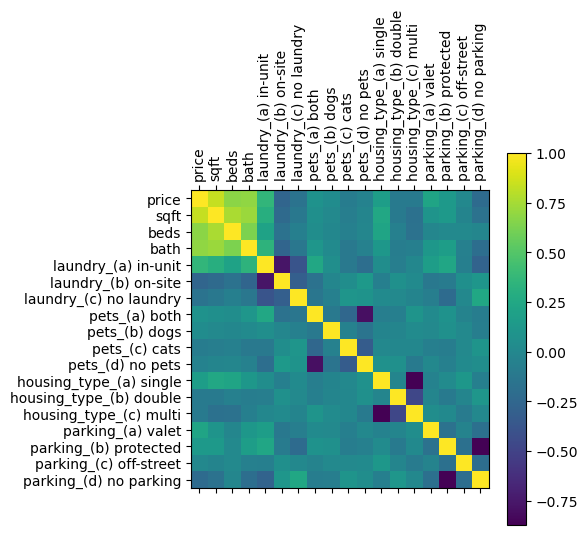

In [23]:
# Ecamine the correlation between features.
sf_corr = sf_fteval.corr()

# Plot relationship
plt.matshow(sf_fteval.corr())
plt.xticks(ticks=range(sf_fteval.shape[1]),labels=sf_fteval.columns,rotation=90)
plt.yticks(ticks=range(sf_fteval.shape[1]),labels=sf_fteval.columns)
plt.colorbar()

([<matplotlib.axis.XTick at 0x261ba3d2b20>,
 [Text(0, 0, 'sqft'),
  Text(1, 0, 'beds'),
  Text(2, 0, 'bath'),
  Text(3, 0, 'laundry_(a) in-unit'),
  Text(4, 0, 'laundry_(b) on-site'),
  Text(5, 0, 'laundry_(c) no laundry'),
  Text(6, 0, 'pets_(a) both'),
  Text(7, 0, 'pets_(b) dogs'),
  Text(8, 0, 'pets_(c) cats'),
  Text(9, 0, 'pets_(d) no pets'),
  Text(10, 0, 'housing_type_(a) single'),
  Text(11, 0, 'housing_type_(b) double'),
  Text(12, 0, 'housing_type_(c) multi'),
  Text(13, 0, 'parking_(a) valet'),
  Text(14, 0, 'parking_(b) protected'),
  Text(15, 0, 'parking_(c) off-street'),
  Text(16, 0, 'parking_(d) no parking')])

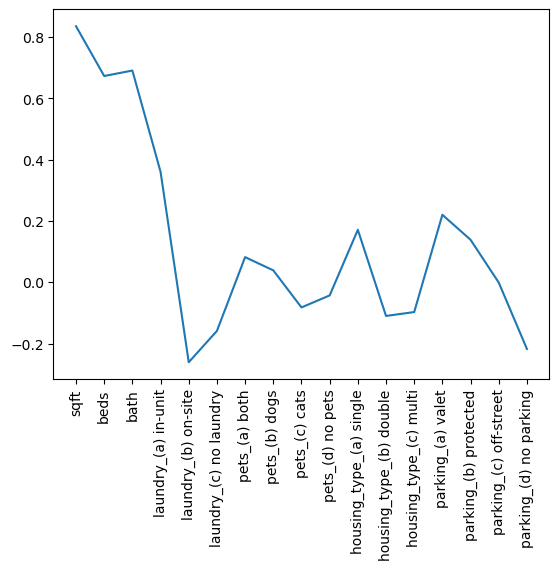

In [61]:
# Unrefined plot of r vs. features

plt.plot(sf_corr.price[1:])
plt.xticks(ticks=range(len(sf_corr.price[1:])),labels=sf_corr.columns[1:],rotation=90)

In [48]:
# Proposal 1: Eliminate features based on correlation with target

# Select a cutoff value for elimination

# Possible values or guides

mean_r = sf_corr.price[1:].mean()
print(f'mean r: {mean_r}')

med_r = sf_corr.price[1:].median()
print(f'median r: {med_r}')

std_r = sf_corr.price[1:].std()
print(f'std r: {std_r}')

mean_r2 = (sf_corr.price[1:]**2).mean()
print(f'mean r2: {mean_r2}')

med_r2 = (sf_corr.price[1:]**2).median()
print(f'median r2: {med_r2}')

std_r2 = (sf_corr.price[1:]**2).std()
print(f'std r2: {std_r2}')

mean r: 0.1318160630865349
median r: 0.03881788093358601
std r: 0.32982670692479016
mean r2: 0.11976197481784642
median r2: 0.025234566055920237
std r2: 0.21011031641021746


In [63]:
# Generate lists above and below cutoff
# In this case the mean or r is chosen

higher_corr = []
low_corr = []
cutoff = mean_r

for ft in sf_corr.price.index:
    if sf_corr[ft][0] <= -cutoff:
        higher_corr.append(ft)
    elif sf_corr[ft][0] >= cutoff:
        higher_corr.append(ft)
    else:
        low_corr.append(ft)
print(f'More Higher Correlated: {higher_corr}')
print(f'Less Correlated: {low_corr}')

More Higher Correlated: ['price', 'sqft', 'beds', 'bath', 'laundry_(a) in-unit', 'laundry_(b) on-site', 'laundry_(c) no laundry', 'housing_type_(a) single', 'parking_(a) valet', 'parking_(b) protected', 'parking_(d) no parking']
Less Correlated: ['pets_(a) both', 'pets_(b) dogs', 'pets_(c) cats', 'pets_(d) no pets', 'housing_type_(b) double', 'housing_type_(c) multi', 'parking_(c) off-street']


In [64]:
# Remove Less correlated variables

sf_final = sf_fteval.copy()

sf_final = sf_final[higher_corr]
sf_final.head(5)

,price,sqft,beds,bath,laundry_(a) in-unit,laundry_(b) on-site,laundry_(c) no laundry,housing_type_(a) single,parking_(a) valet,parking_(b) protected,parking_(d) no parking
0,6800,1600.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3500,550.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5100,1300.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,9000,3500.0,3.0,2.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3100,561.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Preprocess Finalized Feature Set

In [67]:
# Remove target
y = sf_final['price'].values
X = sf_final.drop(columns=['price'], axis=1).values

In [68]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [69]:
# Scale the training data
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Model A: GradientBoostingRegressor

Text(200, 1000000.0, 'Best number of estimators: 57')

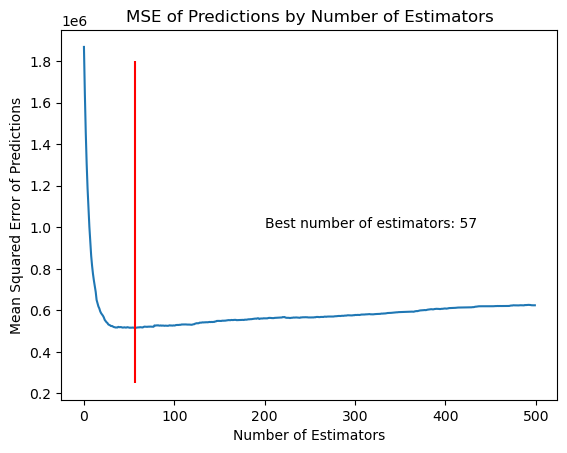

In [71]:
# Create Gradient Boosting Regressor Tree
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=500, random_state=42)

# Fit to training data
gbr.fit(X_train_scaled, y_train)

# Calc. error vals in predictions
errors = [mean_squared_error(y_test, y_pred)
         for y_pred in gbr.staged_predict(X_test_scaled)]

# Determine best number of estimators
best_n_estimators = np.argmin(errors) + 1

plt.plot(range(0,500),errors)
plt.vlines(np.argmin(errors)+1,0.25e6,1.8e6,color='r')
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Squared Error of Predictions")
plt.title("MSE of Predictions by Number of Estimators")
plt.text(200,1e6,f'Best number of estimators: {best_n_estimators}')

In [72]:
# Train GBR based on new n_estimators

gbr = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42)

gbr.fit(X_train_scaled, y_train)

# Display Score
print(f'Training Score: {gbr.score(X_train_scaled, y_train)}')
print(f'Testing Score: {gbr.score(X_test_scaled, y_test)}')

Training Score: 0.8360972252556647
Testing Score: 0.7602926103726112


In [ ]:
# TODO: CV

## Model B: Weighted VotingRegressor

### Create Models to be Used with GBR

In [74]:
# Elastic Net
enet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                   max_iter=5000, cv=10, n_jobs=-1, random_state=42)
enet.fit(X_train_scaled, y_train)

print(f'Train Score: {enet.score(X_train_scaled, y_train)}')
print(f'Test Score: {enet.score(X_test_scaled, y_test)}')

Train Score: 0.7419508371584633
Test Score: 0.7472508997331809


In [75]:
# Random Forest
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_scaled,y_train)

# Display Score
print(f'Training Score: {rfr.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rfr.score(X_test_scaled, y_test)}')

Training Score: 0.9410426268506719
Testing Score: 0.7020422798262653


In [76]:
# TODO: CV

In [123]:
from sklearn.linear_model import TweedieRegressor
tr = TweedieRegressor(power=0, alpha=0, max_iter=1000)
tr.fit(X_train_scaled, y_train)
# Display Score
print(f'Training Score: {tr.score(X_train_scaled, y_train)}')
print(f'Testing Score: {tr.score(X_test_scaled, y_test)}')

Training Score: 0.7422027636622568
Testing Score: 0.7457731696104914


### Minimize MSE of models

In [130]:
# Specify number of estimators
n_est = 4

# Create a 'weights' array with default values of 1/n_est
w = (1/n_est)*np.ones(n_est)
w.shape

(4,)

In [135]:
# Create vector of predicted values from each estimator
enet_pred = enet.predict(X_test_scaled)
gbr_pred = gbr.predict(X_test_scaled)
rfr_pred = rfr.predict(X_test_scaled)
twee_pred = tr.predict(X_test_scaled)

In [137]:
mod_pred = np.column_stack((enet_pred,gbr_pred,rfr_pred,twee_pred))
mod_pred.shape

(248, 4)

In [138]:
# Define Objective Function
def obj_fun(weights=w,y_true=y_test,y_hat=mod_pred, n_estimators=n_est):
    return (1/n_est)*np.sum((y_true - (weights@(y_hat.T)))**2)

In [139]:
# Define constraint(s)
def constraints(weights=w):
    return (1- np.sum(np.abs(weights)))

In [143]:
res = optimize.minimize(obj_fun, (1/n_est)*np.ones(n_est), method='SLSQP',
                  constraints={'fun': constraints,
                              'type': 'eq'}, options={'maxiter': 1000})
res

     fun: 31324758.024630807
     jac: array([-45974224.5 , -43981717.  , -39517598.25, -45823259.  ])
 message: 'Optimization terminated successfully'
    nfev: 194
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([2.60835700e-01, 5.87874308e-01, 1.51286758e-01, 3.23385235e-06])

In [144]:
optimal_mod_weights = res.x
optimal_mod_weights

array([2.60835700e-01, 5.87874308e-01, 1.51286758e-01, 3.23385235e-06])

In [148]:
# Scale weights

# First argsort returns array with first value is the index of the smallest value
# in the array provided
scaled_weights = np.argsort(optimal_mod_weights)

# Second sort returns array firs value the index of the smallest value of input
# Such that the largest value in optimal_mod_weights will have the largest index
# The resulting array has sorted and scaled from len(array) to 0

scaled_weights = np.argsort(scaled_weights)

# Add 1 to prevent zero weights
scaled_weights = scaled_weights + 1
scaled_weights

array([3, 4, 2, 1], dtype=int64)

### Create VotingRegressor with new weights

In [149]:
vrg = VotingRegressor([('enet',enet),('gbr',gbr),
                      ('rfr',rfr),('tweedie',tr)],
                     weights=scaled_weights,
                     n_jobs=-1)

In [150]:
vrg.fit(X_train_scaled, y_train)

# Display Score
print(f'Training Score: {vrg.score(X_train_scaled, y_train)}')
print(f'Testing Score: {vrg.score(X_test_scaled, y_test)}')

Training Score: 0.8420121507609517
Testing Score: 0.7637882773317501
